### set the base params

In [1]:
root = '/home/bob/projects/Web3HackerNetwork'
dataset_dir = root + "/data/github/2022-04-07-marine-search"
stats_dir = dataset_dir + "/projects"

### define a method that finds all files with the same name

In [2]:
import os
def find_all(name, path):
    result = []
    for root, dirs, files in os.walk(path):
        if name in files:
            result.append(os.path.join(root, name))
    return result

### find all the commit stat JSON files

In [3]:
commit_files = find_all('commit-stat.log.json', stats_dir)

### load all the files

In [4]:
import json

all_logs = []
for file in commit_files:
    in_stats = json.loads(open(file, 'r').read());
    all_logs.append(in_stats)
print(all_logs[0][0])

{'commit': 'fb528905fb6448e2b502f7de8fba877a2a995f6d', 'Author': 'tchataigner <tom.chataigner@yahoo.fr>', 'Date': 'Sun Aug 15 20', 'fileTypes': {'js': {'textLineCount': 26, 'binByteCount': 0, 'inserts': 17, 'deletes': 9, 'occurrences': 2}}, 'files': '2', 'insertions(+)': '17', 'deletions(-)\n': '9'}


In [5]:
js_commits = []
rust_commits = []
all_commits = []

js_types = ['js', 'jsx', 'ts', 'tsx']
rust_types = ['rs', 'toml']

for log in all_logs:
    #lines.append("\n")
    for commit in log:
        #lines.append(str(commit['commit']))
        #print(commit['fileTypes'])
        for ft in commit['fileTypes']:
            all_commits.append(commit)
            if ft in js_types:
                js_commits.append(commit)
            elif ft in rust_types:
                rust_commits.append(commit)


### method to extract statistics from the commit data

In [68]:
js_types = ['js', 'jsx', 'ts', 'tsx']
rust_types = ['rs', 'toml']
chars_per_text_line = 30 # just a heuristic for approximating relative weight

def percent(numerator, denominator):
    if (numerator == 0): return 0
    truncated = int(100 * 100 * numerator / denominator)
    return truncated / 100

def extract_stats(commit):
    if 'files' in commit:
        num_files = commit['files']
    else:
        num_files = commit['file']
    typeDict = commit['fileTypes']
    typeArray = [{'fileType': key, 'stats': typeDict[key]} for key in typeDict.keys()]
    textTypeArray = [typeEntry for typeEntry in typeArray if typeEntry['stats']['textLineCount'] > 0]
    binTypeArray = [typeEntry for typeEntry in typeArray if typeEntry['stats']['binByteCount'] > 0]
    jsTypeArray = [typeEntry for typeEntry in typeArray if typeEntry['fileType'] in js_types]
    rsTypeArray = [typeEntry for typeEntry in typeArray if typeEntry['fileType'] in rust_types]
    
    statDict = {}
    statDict['commit'] = commit['commit']
    
    statDict['totalFiles'] = int(num_files)
    statDict['binFiles'] = sum([typeEntry['stats']['occurrences'] for typeEntry in binTypeArray])
    statDict['textFiles'] = sum([typeEntry['stats']['occurrences'] for typeEntry in textTypeArray])
    
    statDict['binBytes'] = sum([typeEntry['stats']['binByteCount'] for typeEntry in binTypeArray])
    statDict['textLines'] = sum([typeEntry['stats']['textLineCount'] for typeEntry in textTypeArray])
    
    statDict['totalBytes'] = statDict['textLines'] * chars_per_text_line + statDict['binBytes']
    statDict['pctBinBytes'] = percent(statDict['binBytes'], statDict['totalBytes'])
    statDict['pctTextBytes'] = percent(statDict['textLines'] * chars_per_text_line, statDict['totalBytes'])
    
    statDict['jsFiles'] = sum([typeEntry['stats']['occurrences'] for typeEntry in jsTypeArray])
    statDict['jsLines'] = sum([typeEntry['stats']['textLineCount'] for typeEntry in jsTypeArray])
    statDict['pctJsFiles'] = percent(statDict['jsFiles'], statDict['totalFiles'])
    statDict['pctJsLines'] = percent(statDict['jsLines'], statDict['textLines'])
    statDict['pctJsBytes'] = percent(statDict['jsLines'] * chars_per_text_line, statDict['totalBytes'])
    
    statDict['rustFiles'] = sum([typeEntry['stats']['occurrences'] for typeEntry in rsTypeArray])
    statDict['rustLines'] = sum([typeEntry['stats']['textLineCount'] for typeEntry in rsTypeArray])
    statDict['pctRustFiles'] = percent(statDict['rustFiles'], statDict['totalFiles'])
    statDict['pctRustLines'] = percent(statDict['rustLines'], statDict['textLines'])
    statDict['pctRustBytes'] = percent(statDict['rustLines'] * chars_per_text_line, statDict['totalBytes'])
    
    return statDict

In [75]:
all_stats = []
commit_map = {}
stat_map = {}

for commit in all_commits:
    commit_id = commit['commit']
    statDict = extract_stats(commit)
    all_stats.append(statDict)
    commit_map[commit_id] = commit
    stat_map[commit_id] = statDict

feature_stat_keys = [
    'pctRustFiles', 'pctJsFiles',
    'pctRustLines', 'pctJsLines',
    'pctRustBytes', 'pctJsBytes',
    'pctBinBytes', 'pctTextBytes'
]

feature_stat_map = {}
all_feature_stats = []
for commit_id in stat_map.keys():
    feature_stats = {}
    feature_stat_map[commit_id] = feature_stats
    for stat_key in feature_stat_keys:
        feature_stats[stat_key] = stat_map[commit_id][stat_key]
    all_feature_stats.append(feature_stats)

count = 0
for commit_id in stat_map.keys():
    count += 1
    if count > 10: break
    # print(commit_map[commit_id])
    # print(stat_map[commit_id])
    print(feature_stat_map[commit_id])
    # print()


{'pctRustFiles': 0, 'pctJsFiles': 100.0, 'pctRustLines': 0, 'pctJsLines': 100.0, 'pctRustBytes': 0, 'pctJsBytes': 100.0, 'pctBinBytes': 0, 'pctTextBytes': 100.0}
{'pctRustFiles': 0, 'pctJsFiles': 0, 'pctRustLines': 0, 'pctJsLines': 0, 'pctRustBytes': 0, 'pctJsBytes': 0, 'pctBinBytes': 0, 'pctTextBytes': 100.0}
{'pctRustFiles': 0, 'pctJsFiles': 0, 'pctRustLines': 0, 'pctJsLines': 0, 'pctRustBytes': 0, 'pctJsBytes': 0, 'pctBinBytes': 0, 'pctTextBytes': 100.0}
{'pctRustFiles': 0, 'pctJsFiles': 0, 'pctRustLines': 0, 'pctJsLines': 0, 'pctRustBytes': 0, 'pctJsBytes': 0, 'pctBinBytes': 0, 'pctTextBytes': 100.0}
{'pctRustFiles': 0, 'pctJsFiles': 0, 'pctRustLines': 0, 'pctJsLines': 0, 'pctRustBytes': 0, 'pctJsBytes': 0, 'pctBinBytes': 0, 'pctTextBytes': 100.0}
{'pctRustFiles': 0, 'pctJsFiles': 100.0, 'pctRustLines': 0, 'pctJsLines': 100.0, 'pctRustBytes': 0, 'pctJsBytes': 100.0, 'pctBinBytes': 0, 'pctTextBytes': 100.0}
{'pctRustFiles': 0, 'pctJsFiles': 0, 'pctRustLines': 0, 'pctJsLines': 0, 'pc

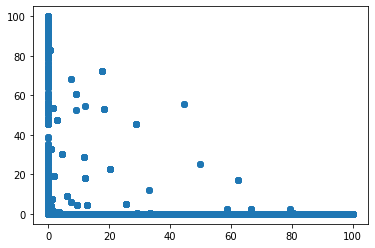

In [77]:
import matplotlib.pyplot as plt
import numpy as np

pct_rust_array = [stats['pctRustBytes'] for stats in all_stats]
pct_js_array = [stats['pctJsBytes'] for stats in all_stats]
xpoints = np.array(pct_rust_array)
ypoints = np.array(pct_js_array)

plt.scatter(xpoints, ypoints)
plt.show()

### scatterplot of Rust % versus Javascript % in each commit
Conclusion: very few commits have a blend of Javascript and Rust

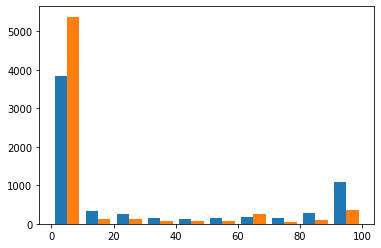

In [76]:
import matplotlib.pyplot as plt
import numpy as np
pct_rust_array = [stats['pctRustBytes'] for stats in all_stats]
pct_js_array = [stats['pctJsBytes'] for stats in all_stats]
plt.hist([np.array(pct_rust_array), np.array(pct_js_array)], 10)
plt.show()

### histogram of commit focus
* what percentage of a commit is Rust? (blue)
* what percentage of a commit is Javascript? (orange)

Conclusion: Most commits are 100% Rust, 100% Javascript, or 0% of Either.

Note: change bin count (the "10" parameter above) to 100 to see that the concentration is really at the extreme endpoints

## Looking for 'Normal' Commits
What would a normal commit look like? It would have more than X lines of text and few or no binary files.

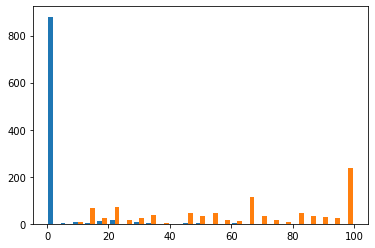

In [93]:
import matplotlib.pyplot as plt
import numpy as np

stats_set = [stats for stats in all_stats
                if stats['binFiles'] == 0
                and stats['textLines'] > 5
                and stats['pctJsBytes'] > 10]

pct_rust_array = [stats['pctRustBytes'] for stats in stats_set]
pct_js_array = [stats['pctJsBytes'] for stats in stats_set]

plt.hist([np.array(pct_rust_array), np.array(pct_js_array)], 25)
plt.show()

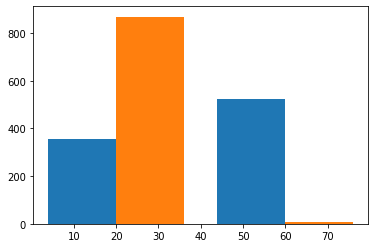

In [120]:
import matplotlib.pyplot as plt
import numpy as np

stats_set = [stats for stats in all_stats
             if stats['binFiles'] == 0
             and stats['textLines'] > 10
             and stats['pctRustBytes'] > 20
             and stats['pctRustBytes'] < 80
            ]

pct_rust_array = [stats['pctRustBytes'] for stats in stats_set]
pct_js_array = [stats['pctJsBytes'] for stats in stats_set]

plt.hist([np.array(pct_rust_array), np.array(pct_js_array)], 2)
plt.show()

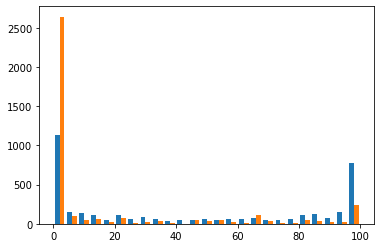

In [91]:
import matplotlib.pyplot as plt
import numpy as np

stats_set = [stats for stats in all_stats
                if stats['binFiles'] == 0
                and stats['textLines'] > 5
                and (stats['pctRustBytes'] > 1 or stats['pctJsBytes'] > 1)]

pct_rust_array = [stats['pctRustBytes'] for stats in stats_set]
pct_js_array = [stats['pctJsBytes'] for stats in stats_set]

plt.hist([np.array(pct_rust_array), np.array(pct_js_array)], 25)
plt.show()